# Introduction

    Wildfires are a dangerous and incredibly destructive phenomenon of nature, which makes understanding and predicting them perimount to curbing their destructive potential in the future. However, there are innumerable factors to consider when trying to predict the effects of a wildfire. Of the two “most important” factors in how wildfires are spread, wind speed is “the most variable and the least predictable.” [1] However, in spite of its variability, its predictive power is immense. So much so that there exists a simple “10% rule” that approximates a wildfire's rate of spread simply through “10% of the average 10-m open wind speed.” [2] This simple model can produce results “comparable to those obtained by the established fire spread rate models” [2] while only accounting for the wind speed factor.

    For our project we aim to put the literature to the test and see just how powerful a factor wind speed truly is for ourselves. We aim to answer the question “What is the difference in average total area burned by a wildfire between times of low wind speed and times of high wind speed?” We would also like to approximate the standard deviation of this difference to see if the results are consistently statistically significant. To answer our question, we have made use of a dataset containing data of the total area burned from 517 forest fires in the northeastern region of Portugal. This dataset also includes the wind speed among other less relevant variables.

# Preliminary Results

In [1]:
# Load the necessary packages.
library(GGally)
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ purrr   0.3.4      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Importing Data

### Table 1: Top 6 Rows of Forest Fires Data

In [2]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
download.file (url,"../data/forestfires.csv" )

forest_fires_data <-read_delim("../data/forestfires.csv", skip=0, delim=",") %>%
    select(wind, area) %>%
    mutate(wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
    filter(!is.na(wind) | !is.na(area))
    
head(forest_fires_data)

Rows: 517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


wind,area
<dbl>,<dbl>
6.7,0
0.9,0
1.3,0
4.0,0
1.8,0
5.4,0


## Wind Speed Distributions

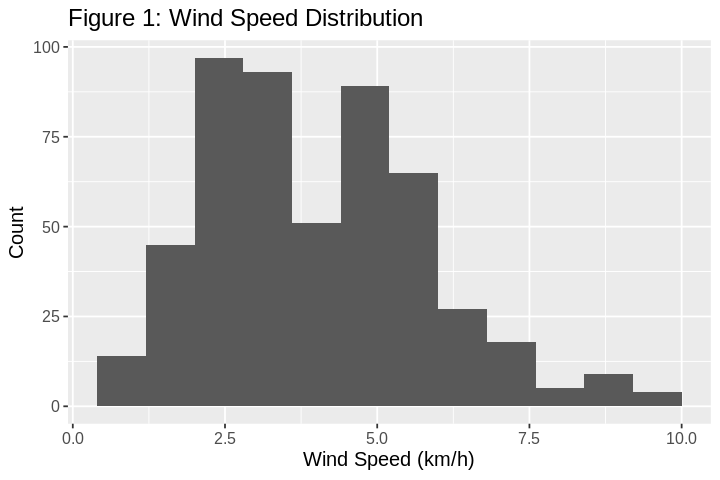

In [3]:
options(repr.plot.width = 6, repr.plot.height = 4)
wind_speed_plot <- forest_fires_data %>%
    ggplot(aes(x = wind))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed (km/h)", y="Count")+
    ggtitle("Figure 1: Wind Speed Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12)) 
wind_speed_plot

Based on figure 1, wind speed is almost a bimodal distribution (without much modification), we can safely assume that we can categorize wind speed into "high" and "low".

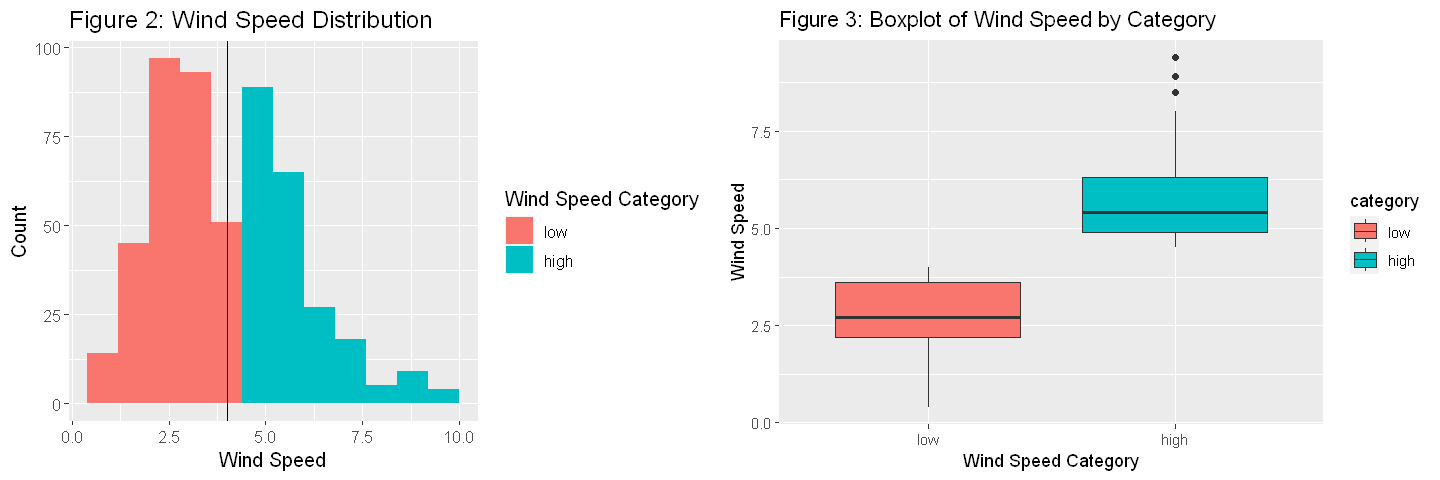

In [9]:
xs <- quantile(forest_fires_data$wind,c(0,1/2,1))

# add category column
forest_fires_data <- forest_fires_data %>%
    mutate(category=cut(wind, breaks=xs, labels=c("low","high"),include.lowest = TRUE))

wind_plot_categorized <- forest_fires_data %>%
    ggplot(aes(x =wind, fill = category))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed", y="Count")+
    ggtitle("Figure 2: Wind Speed Distribution") +
    scale_fill_discrete(name = "Wind Speed Category") +
    theme(text = element_text(size = 12)) + 
    geom_vline(aes(xintercept = quantile(wind)[3]))

box_plot <- forest_fires_data %>%
  ggplot(aes(x = category, y = wind, fill = category)) +
  geom_boxplot() +
  labs(x="Wind Speed Category", y="Wind Speed") +
  ggtitle("Figure 3: Boxplot of Wind Speed by Category") 

options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(wind_plot_categorized, box_plot)

Based on Figure 3, there is a considerable difference in wind speed. A confidence interval would be useful to see if their ranges overlap in a interesting manner. We could also have a confidence interval around the difference of the mean.

## Area Burned Distributions

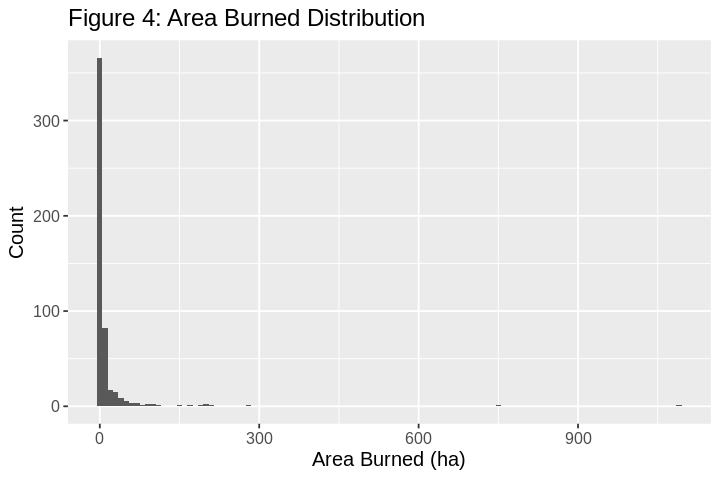

In [5]:
options(repr.plot.width = 6, repr.plot.height = 4)

#Visualizing the distribution of each variable
area_burned_plot <- forest_fires_data %>%
    ggplot(aes(x =area))+
    geom_histogram(binwidth = 10) + 
    labs(x="Area Burned (ha)", y="Count")+
    ggtitle("Figure 4: Area Burned Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12))
area_burned_plot   

Figure 4 shows that it make sense to scale the data in a logrithmic scale.
> See https://www.programmingr.com/tutorial/log-in-r/.

In [6]:
forest_fires_data <- forest_fires_data %>%
    mutate(area_log10 = log10(1+ area))

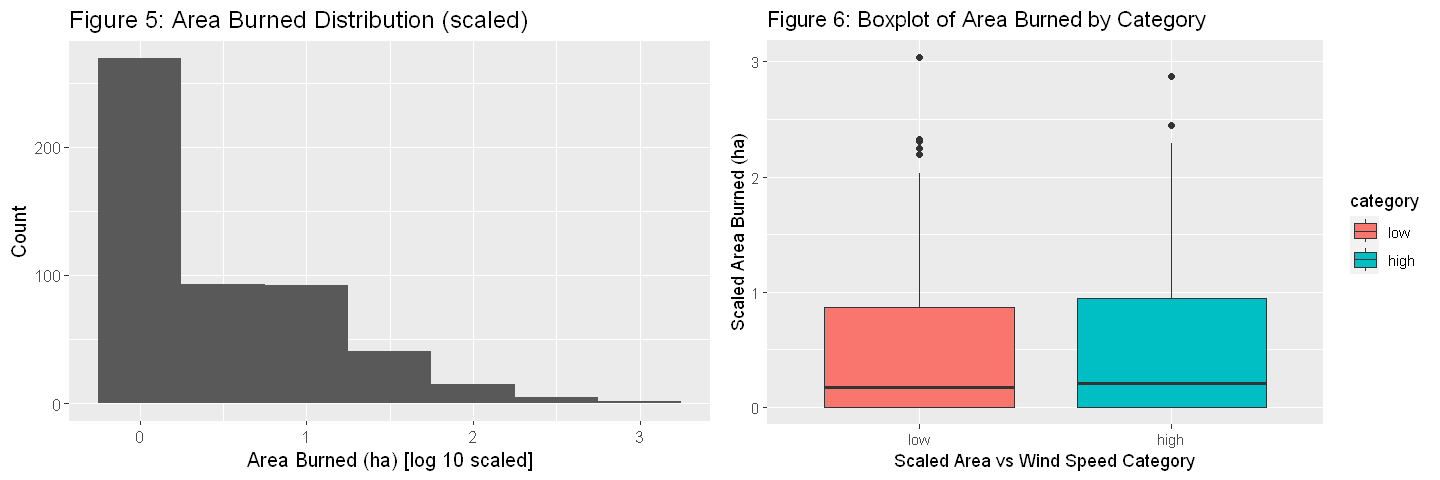

In [7]:
options(repr.plot.width = 6, repr.plot.height = 4)

area_burned_scaled_plot <- forest_fires_data %>%
    ggplot(aes(x =area_log10))+
    geom_histogram(binwidth = 0.5) + 
    labs(x="Area Burned (ha) [log 10 scaled]", y="Count")+
    ggtitle("Figure 5: Area Burned Distribution (scaled)") +
    scale_fill_discrete(name = "Month of Fires") +
    theme(text = element_text(size = 12))

box_plot_burned <- forest_fires_data %>%
  ggplot(aes(x = category, y = area_log10, fill = category)) +
  geom_boxplot() +
  labs(x="Scaled Area vs Wind Speed Category", y="Scaled Area Burned (ha)")+
  ggtitle("Figure 6: Boxplot of Area Burned by Category")

options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(area_burned_scaled_plot, box_plot_burned)

##### Table 2: Summary Statistics of Forest Fires Data

In [8]:
forest_fires_data %>%
group_by(category) %>%
filter(category == "low") %>%
summary()

forest_fires_data %>%
group_by(category) %>%
filter(category == "high") %>%
summary()

      wind            area          category     area_log10    
 Min.   :0.400   Min.   :   0.000   low :300   Min.   :0.0000  
 1st Qu.:2.200   1st Qu.:   0.000   high:  0   1st Qu.:0.0000  
 Median :2.700   Median :   0.495              Median :0.1746  
 Mean   :2.779   Mean   :  12.615              Mean   :0.4699  
 3rd Qu.:3.600   3rd Qu.:   6.365              3rd Qu.:0.8672  
 Max.   :4.000   Max.   :1090.840              Max.   :3.0382  

      wind            area        category     area_log10    
 Min.   :4.500   Min.   :  0.00   low :  0   Min.   :0.0000  
 1st Qu.:4.900   1st Qu.:  0.00   high:217   1st Qu.:0.0000  
 Median :5.400   Median :  0.61              Median :0.2068  
 Mean   :5.729   Mean   : 13.17              Mean   :0.5000  
 3rd Qu.:6.300   3rd Qu.:  7.73              3rd Qu.:0.9410  
 Max.   :9.400   Max.   :746.28              Max.   :2.8735  

# Method Plan
The methods used to generate this report can be considered trustworthy based on:
- The data is coming from a peer reviewed research that is publicly available.
- the dataset is quite large, encompassing over 500 data points
- All the N/A values are removed from the dataset and the response variable is transformed using a log function to have a less skewed distribution.
    - to account for the data points where the area burned was 0, we uniformly added 1 to every data point so that the differences between the data points are retained

In relation to research question, our null hypothesis states that we will not see a difference in the area burned between the two wind speed categories.

## Is it enough?
The preliminary results seen seem to suggest that there may not be considerable differences in area burned when wind is categorized as high or low. 

However, the plots we produced are not enough to come to a conclusion because we do not know the significance we see in the differences in the area burned in the 2 different categories. To be able to confidently say if the results we see from the data significantly differenciates from the null hypothesis, and suggest that wind speed does have an effect on area burned we need to properly conduct a hypothesis test of the difference in means, and produce a confidence intervals around this difference in means.

## Plan for Further Research
Our plan is to include:
- hypothesis test around the difference in means of area burned across the two wind categories
- a confidence interval around this difference in means
- a bootstrap distribution pulled from our sample data 
    - which could be used to produce that confidence interval
- calculate the p-value to find it's likelyhood under the null hypothesis
- the t-value and compare it to the sample's t-distribution 

## Expectations
From eyeballing the preliminary results, we don't expect to find a significant difference in means from the two categories. These results might suggest that the wind speed isn't as important to track for predicting the severity of wildfires (at least in Portugal). However, it also might point for a need for more comprehensive data over a longer span of time, or that the data collected for this sample needs to track more information about the wind's behaviour outside of the wind speed to be able to produce a better predictive model.

### Reflection
The results from this project could signify to bodies that care about wildfires that wind speed isn't enough to be able to predict the severity of future wild fires (the dependency on this single variable is dangerous), and that there needs to be more investment in finding a property that better fits their forest.

### More Research Needed

Is it understandable that wind speed is a relatively easy attribute to measure for wind, thus an attractive variable to depend upon for simplistic models. 

Our research could point for a need for new comprehensive methods of measuring other wind properties, which could generate questions around what are the other properties that give the most accurate results of predicting area burned. It could also point to questions whether the most predictive properties are dependent on other properties of the environment that are not wind, and include those into predictive models. 

# References

[1] General Winds | NWCG. (n.d.). Retrieved November 4, 2022, from https://www.nwcg.gov/publications/pms425-1/general-winds 

[2] Cruz, M. G. (2019, April 25). The 10% wind speed rule of thumb for estimating a wildfire’s forward rate of spread in forests and shrublands - Annals of Forest Science. BioMed Central. https://annforsci.biomedcentral.com/articles/10.1007/s13595-019-0829-8
